이 대회에서는 자동차 보험 계약자가 클레임을 제기 할 확률을 예측합니다.

기차 및 테스트 데이터에서 기능이 유사한 그룹에 기능 이름에 같은 태그 속해 (예를 들어, ind, reg, car, calc). 또한 기능 이름에는 bin이진 기능 cat을 표시하고 범주 기능을 나타내는 접미사 가 포함 됩니다. 이러한 지정이없는 기능은 연속 형이거나 순서 형입니다. 의 값은 -1기능이 관찰에서 누락되었음을 나타냅니다. target열 의미는 주장은 보험 계약자 소송을 제기되었는지 여부.

https://yseon99.tistory.com/56


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import time

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train.head(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
test.head(5)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [ ]:
submission.head() # 결과물 제출 형식

,id,target
0,0,0.0364
1,1,0.0364
2,2,0.0364
3,3,0.0364
4,4,0.0364


In [ ]:
print(train.columns)
print("="*80)
print(test.columns)

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [ ]:
print("train 행 길이:",train.shape[0],"train 열(컬럼) 길이 :",len(train.columns)) # train.shape()
print("="*45)
print("test 행 길이:",test.shape[0],"test 열(컬럼) 길이 :",len(test.columns)) # test.shape()

train 행 길이: 595212 train 열(컬럼) 길이 : 59
test 행 길이: 892816 test 열(컬럼) 길이 : 58


In [ ]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

In [ ]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 59 entries, id to ps_calc_20_bin
dtypes: float64(10), int64(49)
memory usage: 267.9 MB


In [ ]:
train['target'].value_counts()

0    573518
1     21694
Name: target, dtype: int64

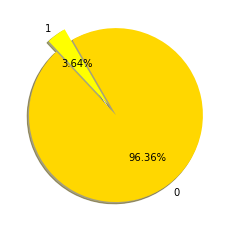

In [ ]:
labels = '1', '0'
sizes = [train[train.target==1].shape[0],train[train.target==0].shape[0]]
colors = ['yellow', 'gold']
explode = (0.15, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.2f%%', shadow=True, startangle=120)
plt.show()

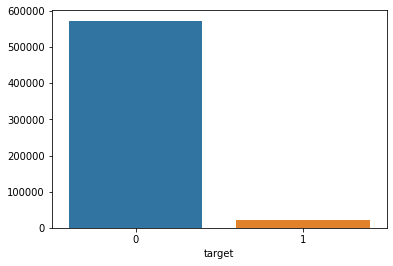

In [ ]:
long = train.groupby(['target'])['id'].count()
sns.barplot(x=long.index,y=long.values)

In [ ]:
print(train.isnull().sum()) #결측치 확인
print("결측치 총합 :",train.isnull().sum().sum()) #결측치 총합

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [ ]:
#컬럼이름 앞에 : ind, reg, car, calc
#컬럼이름 뒤에 : _bin(binary Features), _cat(Categorical Features), 붙어있지않은것
# -1은 missing value 누락값을 의미한다. (missing value = mv)

In [ ]:
train.columns[train.columns.str.contains("ind")]

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin'],
      dtype='object')

In [ ]:
train.columns[train.columns.str.contains("reg")]

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03'], dtype='object')

In [ ]:
train.columns[train.columns.str.contains("car")]

Index(['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15'],
      dtype='object')

In [ ]:
train.columns[train.columns.str.contains("calc")]

Index(['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

In [ ]:
train.columns[train.columns.str.contains("_bin")]

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='object')

In [ ]:
train.columns[train.columns.str.contains("_cat")]

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [ ]:
# ind는 ind끼리 reg는 reg끼리 car은 car끼리 calc은 calc끼리 시각화를 하기 위해서 나눔
list0 = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin']
list1 = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03']
list2 = ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']
list3 = ['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10',
       'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin']

In [ ]:
# _bin 은 _bin 끼리 _cat 은 _cat 끼리
list_bin = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin']
list_cat = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat']

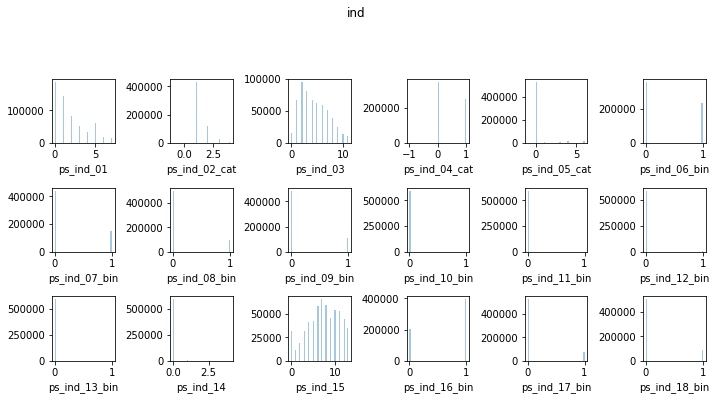

In [ ]:
i = 0
for col in list0:
    i += 1
    fig = plt.figure(1, figsize=(10,10))
    ax1 = fig.add_subplot(6, 6, i)    
    sns.distplot(train[col], kde=False)        
fig.suptitle('ind')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

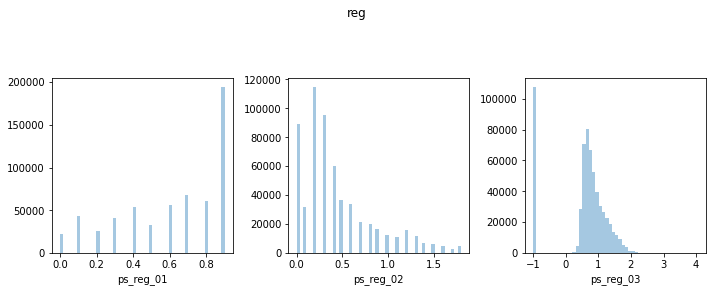

In [ ]:
i = 0
for col in list1:
    i += 1
    fig = plt.figure(1, figsize=(10,10))
    ax1 = fig.add_subplot(3, 3, i)    
    sns.distplot(train[col], kde=False)        
fig.suptitle('reg')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

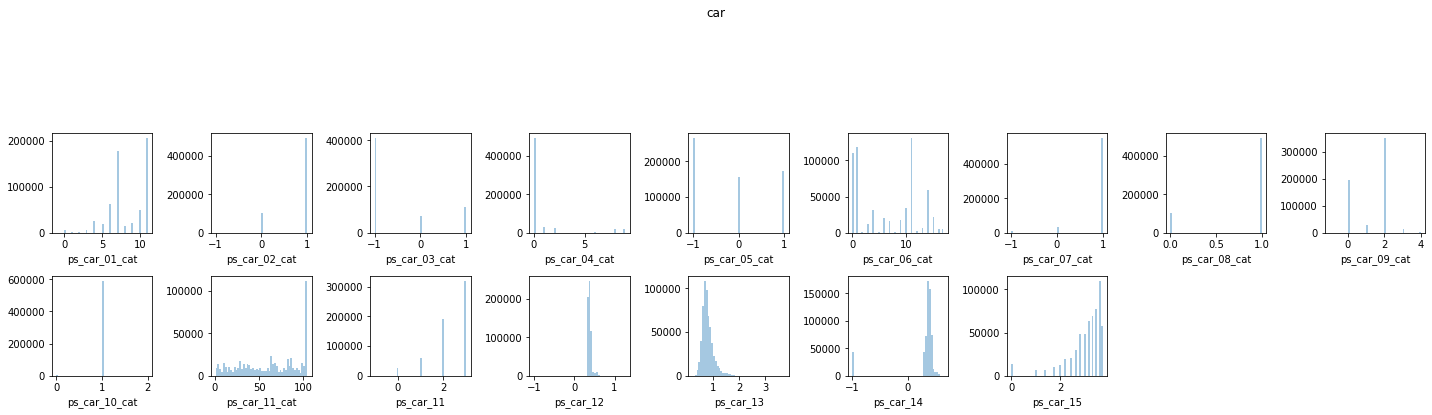

In [ ]:
i = 0
for col in list2:
    i += 1
    fig = plt.figure(1, figsize=(20,20))
    ax1 = fig.add_subplot(9, 9, i)    
    sns.distplot(train[col], kde=False)        
fig.suptitle('car')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

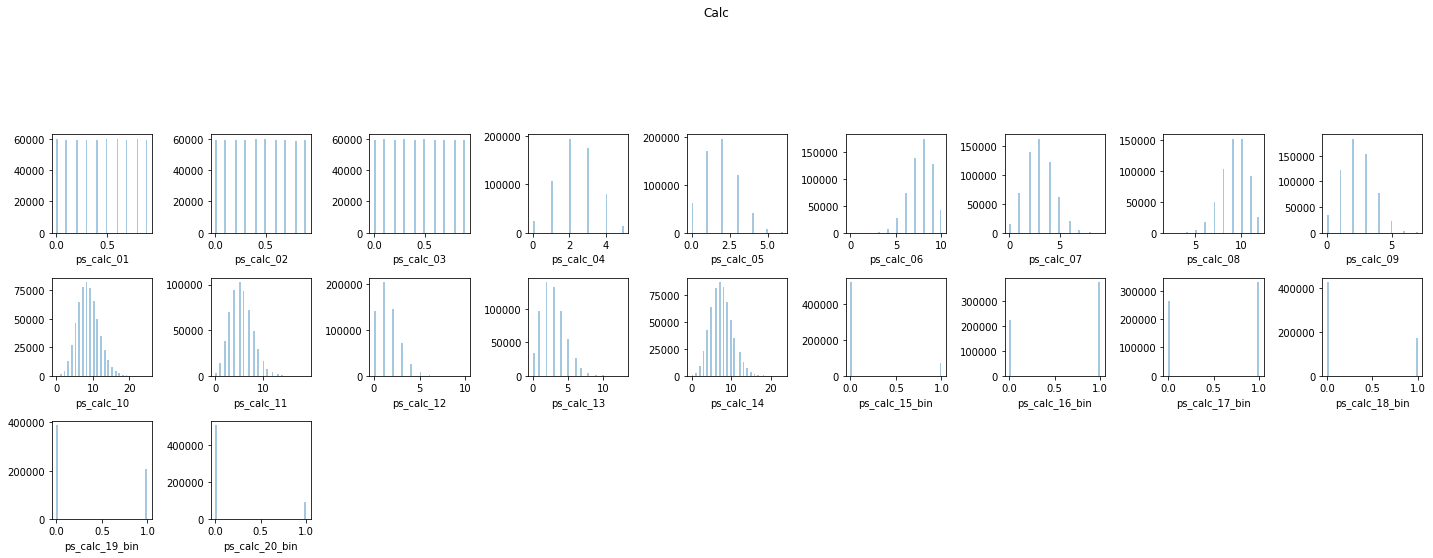

In [ ]:
i = 0
for col in list3:
    i += 1
    fig = plt.figure(1, figsize=(20,20))
    ax1 = fig.add_subplot(9, 9, i)    
    sns.distplot(train[col], kde=False)
fig.suptitle('Calc')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

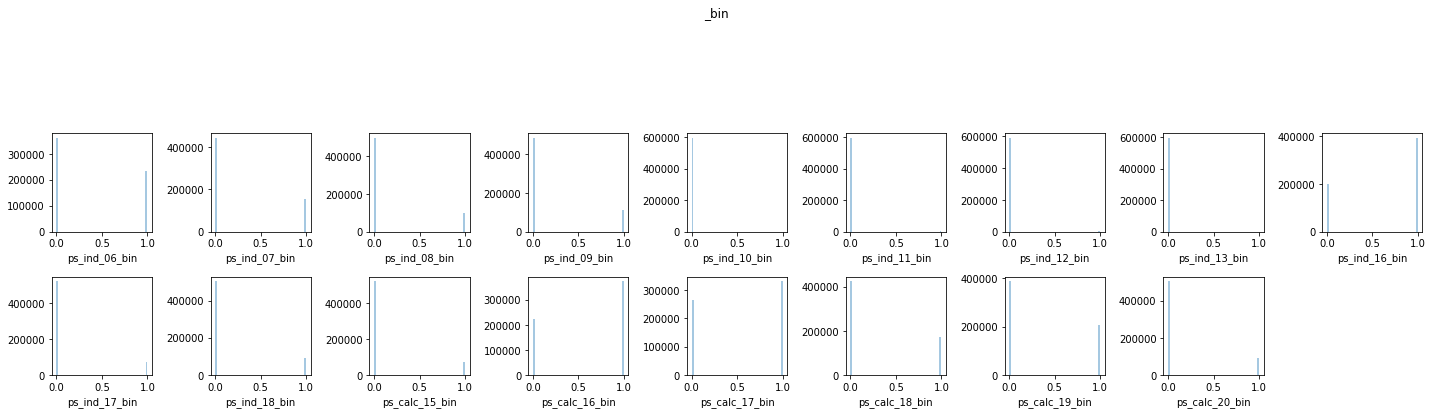

In [ ]:
i = 0
for col in list_bin:
    i += 1
    fig = plt.figure(1, figsize=(20,20))
    ax1 = fig.add_subplot(9, 9, i)    
    sns.distplot(train[col], kde=False)
fig.suptitle('_bin')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

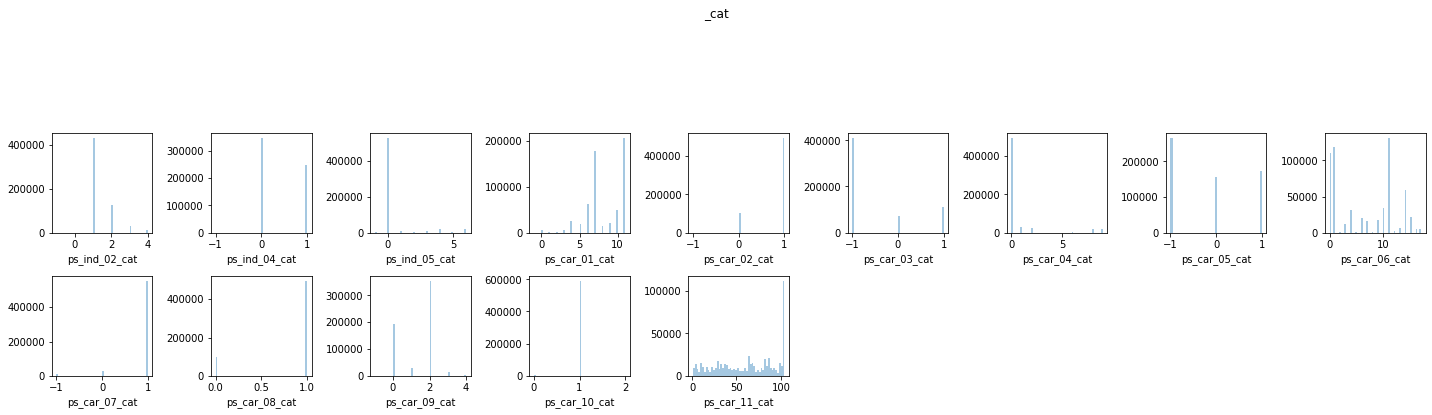

In [ ]:
i = 0
for col in list_cat:
    i += 1
    fig = plt.figure(1, figsize=(20,20))
    ax1 = fig.add_subplot(9, 9, i)    
    sns.distplot(train[col], kde=False)
fig.suptitle('_cat')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

데이터 전처리

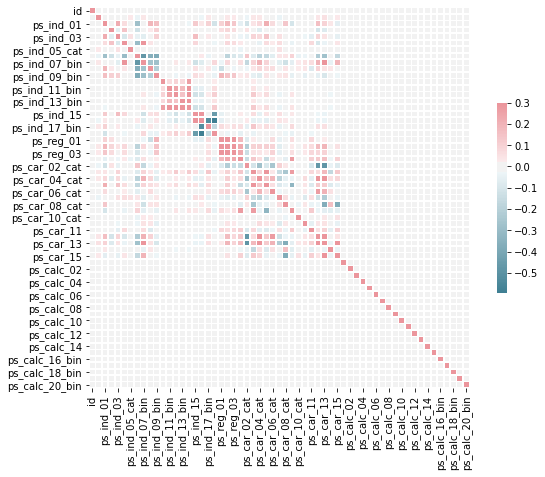

In [ ]:
corr = train.corr()
plt.subplots(figsize=(10,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # 히트맵 스타일
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.7, cbar_kws={"shrink": .5})
plt.show()
#히트맵 결과 컬럼이름에 ps_calc이 들어가있는 것들이 상관관계가 0 이다. 따라서 불필요 

In [ ]:
# 상관관계가 0인 세세한 부분들을 찾아서 지우기
#상관계수가 0인 것들을 따로 replace로 찾아서 대체하기

In [ ]:
calc_drop = list(train.columns[train.columns.str.contains("calc")])
train = train.drop(calc_drop, axis=1)  
test = test.drop(calc_drop, axis=1)

In [ ]:
train.columns # 삭제완료

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15'],
      dtype='object')

In [ ]:
# -1인 mv값들의 개수확인을 해보았다.
for n in train.columns:
  null = train[train[n] == -1][n].count()
  print(n,":",null)

id : 0
target : 0
ps_ind_01 : 0
ps_ind_02_cat : 216
ps_ind_03 : 0
ps_ind_04_cat : 83
ps_ind_05_cat : 5809
ps_ind_06_bin : 0
ps_ind_07_bin : 0
ps_ind_08_bin : 0
ps_ind_09_bin : 0
ps_ind_10_bin : 0
ps_ind_11_bin : 0
ps_ind_12_bin : 0
ps_ind_13_bin : 0
ps_ind_14 : 0
ps_ind_15 : 0
ps_ind_16_bin : 0
ps_ind_17_bin : 0
ps_ind_18_bin : 0
ps_reg_01 : 0
ps_reg_02 : 0
ps_reg_03 : 107772
ps_car_01_cat : 107
ps_car_02_cat : 5
ps_car_03_cat : 411231
ps_car_04_cat : 0
ps_car_05_cat : 266551
ps_car_06_cat : 0
ps_car_07_cat : 11489
ps_car_08_cat : 0
ps_car_09_cat : 569
ps_car_10_cat : 0
ps_car_11_cat : 0
ps_car_11 : 5
ps_car_12 : 1
ps_car_13 : 0
ps_car_14 : 42620
ps_car_15 : 0


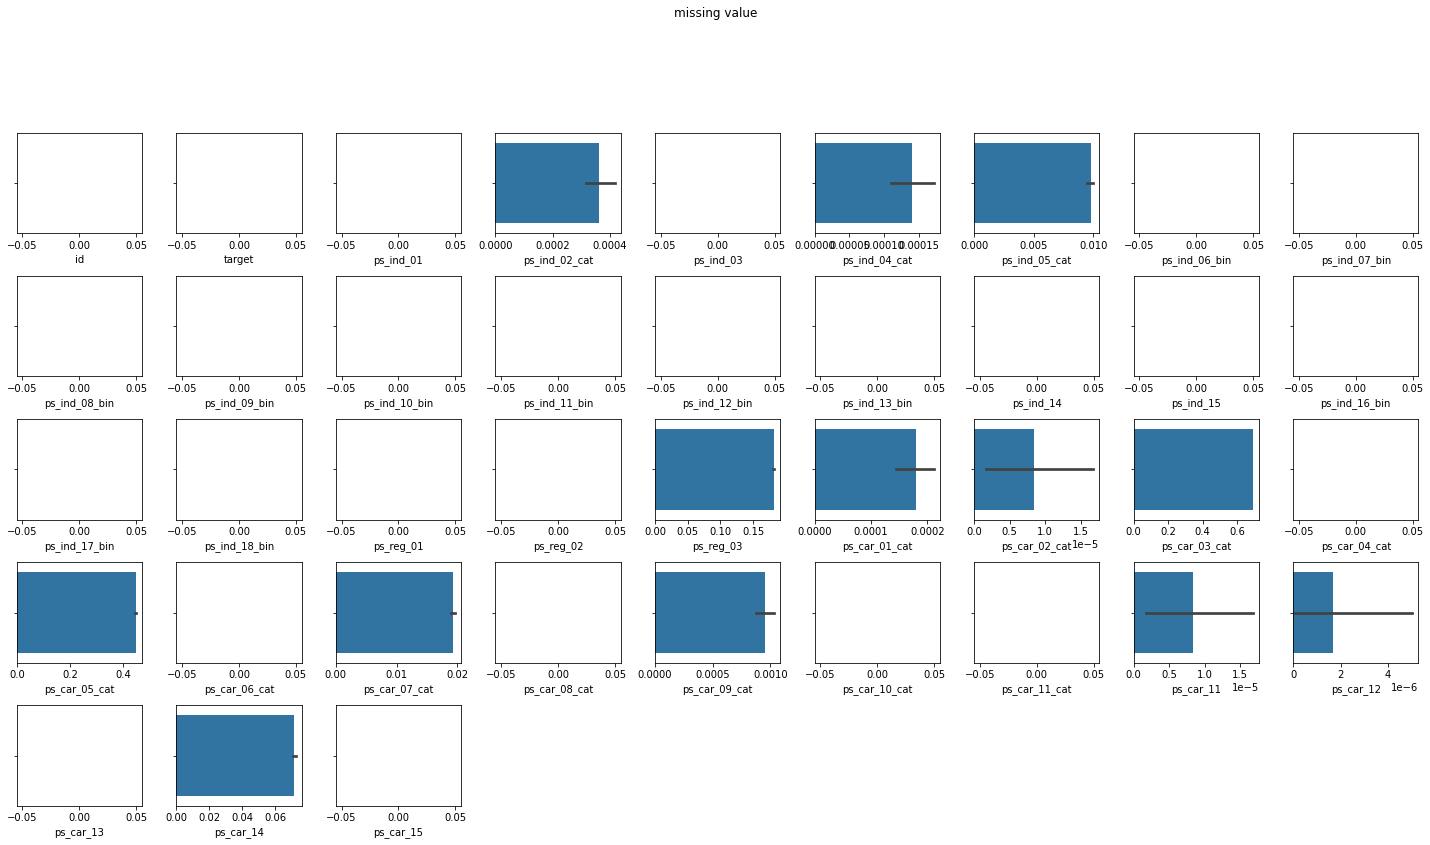

In [ ]:
# missing value 시각화 따라서 ps_car_03_cat,ps_car_05_cat 컬럼의 missing value값이 매우 큰걸 확인
i = 0
for col in train.columns:
    i += 1
    fig = plt.figure(1, figsize=(20,20))
    ax1 = fig.add_subplot(9, 9, i)    
    sns.barplot(train[col]==-1)
fig.suptitle('missing value')
fig.tight_layout(rect=[0, 0.02, 1, 0.9])

In [ ]:
# 결과 ps_car_03_cat,ps_car_05_cat 은 mv값이 너무 많기때문에 삭제처리를 한다.
drop_columns = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(drop_columns, inplace=True, axis=1)
test.drop(drop_columns, inplace=True, axis=1)

In [ ]:
# 내일은 여기서 부터  missing value 인 -1을 결측치로 바꾸고 결측치를 각 컬럼의 mean 또는 mode로 값을 채워주기
datasum = [train,test]
for nan in datasum:
  nan.replace(to_replace=-1,value=np.nan)

필사부분 - Feature Engineering

In [ ]:
# 필사부분 (결측치값을 mode[0]로 대체)
for i, feature in enumerate(list(train.drop(['id'], axis=1))):
    if train[feature].isnull().sum() > 0:
        print(train['feature'])
        train[feature].fillna(train[feature].mode()[0],inplace=True)

for i, feature in enumerate(list(test.drop(['id'], axis=1))):
    if test[feature].isnull().sum() > 0:
        print(test['feature'])
        test[feature].fillna(test[feature].mode()[0],inplace=True)

In [ ]:
# 필사부분 (Transform category features to dummies)

id_test = test['id'].values
y = train['target'].values

train = train.drop(['target','id'], axis = 1)
test = test.drop(['id'], axis = 1)

cat_features = [a for a in train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(train[column]))
    train = pd.concat([train,temp],axis=1)
    train = train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(test[column]))
    test = pd.concat([test,temp],axis=1)
    test = test.drop([column],axis=1)

print(train.values.shape, test.values.shape)

(595212, 201) (892816, 201)


Gini coeficient

In [ ]:
# Gini coeficient
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

Ensembling

In [ ]:
# Ensembling
from sklearn.model_selection import StratifiedKFold

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=random_state).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                clf.fit(X_train, y_train)
                valid_pred = clf.predict_proba(X_valid)[:,1]
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            print( "\nTraining Gini for model {} : {}".format(i, eval_gini(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

모델 & 예측하기

In [ ]:
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['random_state'] = random_state
lgb_params['scale_pos_weight'] = 3

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 750
lgb_params2['max_bin'] = 18
lgb_params2['subsample'] = 0.8
lgb_params2['subsample_freq'] = 10
lgb_params2['colsample_bytree'] = 0.8   
lgb_params2['min_child_samples'] = 790
lgb_params2['random_state'] = random_state
lgb_params2['scale_pos_weight'] = 3

lgb_params3 = {
    'n_estimators' : 110,
    'max_depth' : 4,
    'learning_rate' : 0.02,
    'seed' : 99
}

lgb_params4 = {
    'learning_rate' : 0.02,
    'n_estimators' : 650,
    'max_bin' : 10,
    'subsample' : 0.8,
    'subsample_freq' : 10,
    'colsample_bytree' : 0.8,
    'min_child_samples' : 500,
    'seed' : 99
}

lgb_params5 = {
    'n_estimators' : 1090,
    'learning_rate' : 0.02,
    'colsample_bytree' : 0.3,
    'subsample' : 0.7,
    'subsample_freq' : 2,
    'num_leaves' : 16,
    'seed' : 99
}

lgb_model1 = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
lgb_model4 = LGBMClassifier(**lgb_params4)
lgb_model5 = LGBMClassifier(**lgb_params5)

lgb_stack = Create_ensemble(n_splits = 5, base_models = [lgb_model1, lgb_model2, lgb_model3, lgb_model4, lgb_model5])        
X = train
Y = y
T = test
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)


Training Gini for model 0 : 0.2836366995464875

Training Gini for model 1 : 0.2826126551063124

Training Gini for model 2 : 0.2608737702862003

Training Gini for model 3 : 0.2839934744909286

Training Gini for model 4 : 0.2835953974928638


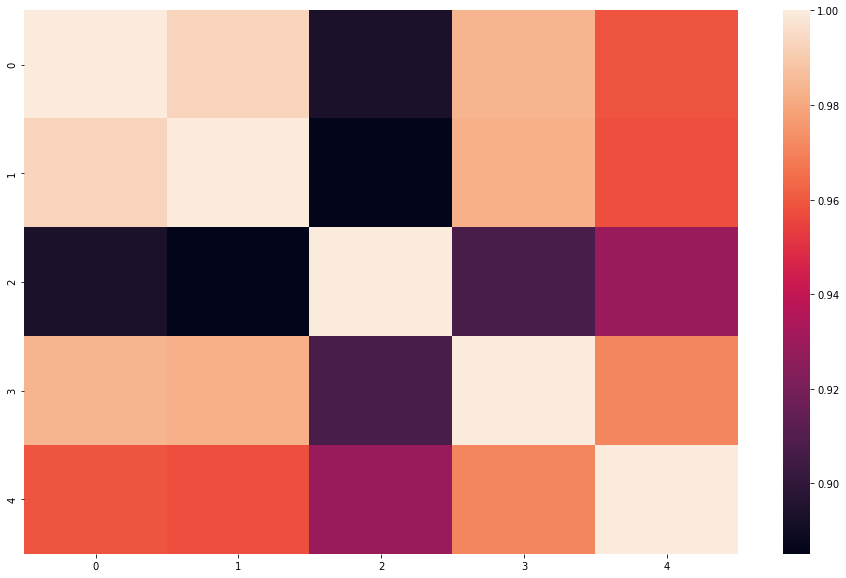

In [ ]:
import seaborn as sns
test_pred_df = pd.DataFrame(data = lgb_test_pred)
cor = test_pred_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

In [ ]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lgb_test_pred.mean(axis=1)
sub.to_csv('ensemble_my_submission.csv', float_format='%.6f', index=False)

In [ ]:
sub.head()

,id,target
0,0,0.050477
1,1,0.043790
2,2,0.041701
3,3,0.026843
4,4,0.063785


https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/submissions
